# <center>Бэггинг. Случайный лес</center>

# <center>Часть 1. Random Forest</center>
<br>
<img src="https://c.mql5.com/2/30/Untitled_Diagram_j3i.png" width="1000px"/><br>

- Почти как **bagging** над **Decision Trees**, где элемент рандома есть на этапе формирования обучающих выборок с помощью **bootstrap**
- Только ещё рандом добавлен на этапе построения деревьев (каждый раз разбиение вершины дерева подбирается не среди всех признаков, а среди случайно выбранных $m$ из них)
- Деревья становятся более разнообразными, а весь лес менее переобученным
- Для задачи **классификации** рекомендуется брать $m = \sqrt{n}$, а для задачи **регрессии** $m = \frac{n}{3}$, где $n$ - число признаков

**Достоинствами являются:**

- Имеет высокую точность предсказания, часто лучше линейных алгоритмов
- Не нужно масштабировать данные и убирать выбросы
- Показывает хорошие результаты и без подбора гиперпараметров (если постараться можно улучшить точность где то на 0.1 - 0.3)
- Хорошо работает и с категориальными признаками
- Редко переобучается, скорее начиная с некоторого числа деревьев в композиции точность перестанет увеличиваться
- Процесс обучения хорошо параллелится

**Недостатки:**

- Теряем интерпретируемость деревьев, так как их много
- Работает хуже линейных методов, когда в выборке очень много разреженных признаков
- Переобучается на зашумленных данных
- Леса занимают много памяти

## Чтение данных

Возьмём датасет поведения клиентов телекоммуникационной компании, который можно скачать [тут](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

Будем решать задачу предсказания собирается ли клиент перестать пользоватся услугами компании и, например, уйти к конкурентам. Это задача классификации, результирующую модель можно использовать для разработки целенаправленных программ по удержанию клиентов.

Датасет содержит:
- **Churn** ––– ушли ли клиенты в течение последнего месяца (целевой признак)
- Подписки клиента на разных сервисы ––– phone, multiple lines, internet, online security, online backup, device protection, tech support, streaming TV and movies
- Информация об аккаунте клиента ––– how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Демографическая информация о клиенте ––– gender, age range, and if they have partners and dependents

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

df = pd.read_csv("../../data/telecom/telecom.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [2]:
from sklearn.preprocessing import OneHotEncoder # закодируем категориальные нецелвые признаки

df = df.drop(["State"], axis=1) # много значений штатов, уберём, но в будущем можно попробовать оставить

enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['International plan', 'Voice mail plan']]).toarray())
enc_df.columns = enc.get_feature_names(['International plan', 'Voice mail plan']) # дадим понятные имена колонкам

df.drop(['International plan', 'Voice mail plan'] ,axis=1, inplace=True) # удалим старые

df = df.join(enc_df)
df

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,...,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,11.01,10.0,3,2.70,1,False,1.0,0.0,0.0,1.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,11.45,13.7,3,3.70,1,False,1.0,0.0,0.0,1.0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,7.32,12.2,5,3.29,0,False,1.0,0.0,1.0,0.0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,8.86,6.6,7,1.78,2,False,0.0,1.0,1.0,0.0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,8.41,10.1,3,2.73,3,False,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,...,12.56,9.9,6,2.67,2,False,1.0,0.0,0.0,1.0
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,...,8.61,9.6,4,2.59,3,False,1.0,0.0,1.0,0.0
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,...,8.64,14.1,6,3.81,2,False,1.0,0.0,1.0,0.0
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,...,6.26,5.0,10,1.35,2,False,0.0,1.0,1.0,0.0


In [3]:
y = df["Churn"]
X = df.drop(["Churn"], axis=1)
X

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1.0,0.0,0.0,1.0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1.0,0.0,0.0,1.0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,1.0,0.0,1.0,0.0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0,1.0,1.0,0.0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,1.0,0.0,0.0,1.0
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,1.0,0.0,1.0,0.0
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,1.0,0.0,1.0,0.0
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0.0,1.0,1.0,0.0


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score 

# Инициализируем стратифицированную разбивку нашего датасета для валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Инициализируем наш классификатор с дефолтными параметрами
random_forest = RandomForestClassifier(random_state=24)

# Обучаем на тренировочном датасете
results = cross_val_score(random_forest, X, y, cv=cv)

# Оцениваем точность на тестовом датасете
print("Accuracy of the first Random Forest: {:.4f}".format(results.mean()))

Accuracy of the first Random Forest: 0.9538


In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split

model_accuracies = {}  # сюда будем сохранять качество натренированных моделей

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=55)

n_estimators = [5, 50, 100]
criterion = ["gini", "entropy"]
#splitter = ["best", "random"] - этого параметра нету для random forest
max_depth = [2, 10, 20]
min_samples_split = [2, 4, 10]
min_samples_leaf = [1, 2, 6]
max_features = [2, 4, 8, len(X_train.columns)]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

random_forest = RandomForestClassifier(random_state=33, n_jobs=-1, oob_score=True)

grid_rf = GridSearchCV(estimator=random_forest, cv=cv, 
        param_grid=dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                        max_features=max_features))
grid_rf.fit(X_train, y_train)
print("best score: ", grid_rf.best_score_)
print("best param: ", grid_rf.best_params_)
model_accuracies['Random Forest'] = grid_rf.score(X_test, y_test)
print("test score:", model_accuracies['Random Forest'])

best score:  0.9528503552030585
best param:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
test score: 0.965


In [6]:
print("Accuracy of Random Forest: {:.4f}".format(model_accuracies['Random Forest']))

Accuracy of Random Forest: 0.9650


## <center>Часть 2. Bagging Decision Tree Classifier</center>

Посмотрим теперь просто на **bagging** над решающими деревьями. Тут уже решающие деревья не обязательно используют случайные подмножества признаков при разбиении вершины на две. Можно настраивать параметры обычных деревьев и настраивать их количество. В данном случае подберём только их количество.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

n_estimators = [5, 50, 100, 300]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

bagging_dt = BaggingClassifier(DecisionTreeClassifier(), random_state=10)

grid_bdt = GridSearchCV(estimator=bagging_dt, cv=cv, 
        param_grid=dict(n_estimators=n_estimators))
grid_bdt.fit(X_train, y_train)
print("best score: ", grid_bdt.best_score_)
print("best param: ", grid_bdt.best_params_)
model_accuracies['Bagging Decision Tree'] = grid_bdt.score(X_test, y_test)
print("test score:", model_accuracies['Bagging Decision Tree'])

best score:  0.94298370569152
best param:  {'n_estimators': 300}
test score: 0.959


In [8]:
print("Accuracy of Bagging Decision Tree: {:.4f}".format(model_accuracies['Bagging Decision Tree']))

Accuracy of Bagging Decision Tree: 0.9590


## <center>Часть 3. Single Decision Tree</center>
<br>
<img src="https://christophm.github.io/interpretable-ml-book/images/tree-artificial-1.jpeg" width="600px"/><br>

**Decision trees (DTs)** могут быть использованы, например, для решения задач классификации, регрессии.

Достоинствами являются:

- Восстановление нелинейных зависимостей произвольной сложности
- Не требуется выбирать заранее тип нелинейности
- Не нужно масштабировать данные
- Высокая интерпетируемость результатов
- Для задачи классификации можно получить вероятности принадлежности к каждому классу
- Хорошо объединяются в композиции –– решающие леса, которые являются одними из наиболее сильных и универсальных моделей

Недостатки:

- Слабые результаты, если обучать только одно дерево
- Склонны к переобучению
- Для повышения качества необходимо настраивать больше количество параметров

### Построение первой модели

In [9]:
from sklearn.preprocessing import StandardScaler

decision_tree = DecisionTreeClassifier(random_state=31)
decision_tree.fit(X_train, y_train)
print("train accuracy:", decision_tree.score(X_train, y_train))
print("test accuracy:", decision_tree.score(X_test, y_test))

train accuracy: 1.0
test accuracy: 0.915


### Подбор гиперпараметров с помощью GridSearchCV и StratifiedKFold

Некоторые параметры sklearn.tree.DecisionTreeClassifier:

- criterion : {“gini”, “entropy”, “log_loss”}, default=”gini” –– функция для оценки качества разбиений 
- splitter : {“best”, “random”}, default=”best” –– стратегия разбиения для каждой вершины
- max_depth : int, default=None –– ограничение на максимальную глубину дерева
- min_samples_split : int or float, default=2 –– минимальное число (если float, то доля от выборки) объектов для продолжения разбиений
- min_samples_leaf : int or float, default=1 –– минимальное количество/доля объектов для вершин
- max_features: int, float or {“auto”, “sqrt”, “log2”}, default=None –– количество признаков для рассмотрения при выборе лучшего разбиения

Про гиперпараметры DecisionTreeClassifier можно найти информацию [тут](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9]
min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12]
max_features = [2, 4, 8, len(X_train.columns)]

cv = StratifiedKFold(5)

decision_tree = DecisionTreeClassifier(random_state=81)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv, 
        param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                        max_features= max_features), refit='Accuracy')
grid_dt.fit(X_train, y_train)
print("best score: ", grid_dt.best_score_)
print("best param: ", grid_dt.best_params_)
model_accuracies['Decision Tree'] = grid_dt.score(X_test, y_test)
print("test score:", model_accuracies['Decision Tree'])

best score:  0.9391283969451617
best param:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 20, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'best'}
test score: 0.945


In [11]:
print("Accuracy of Decision Tree: {:.4f}".format(model_accuracies['Decision Tree']))

Accuracy of Decision Tree: 0.9450


## Результаты

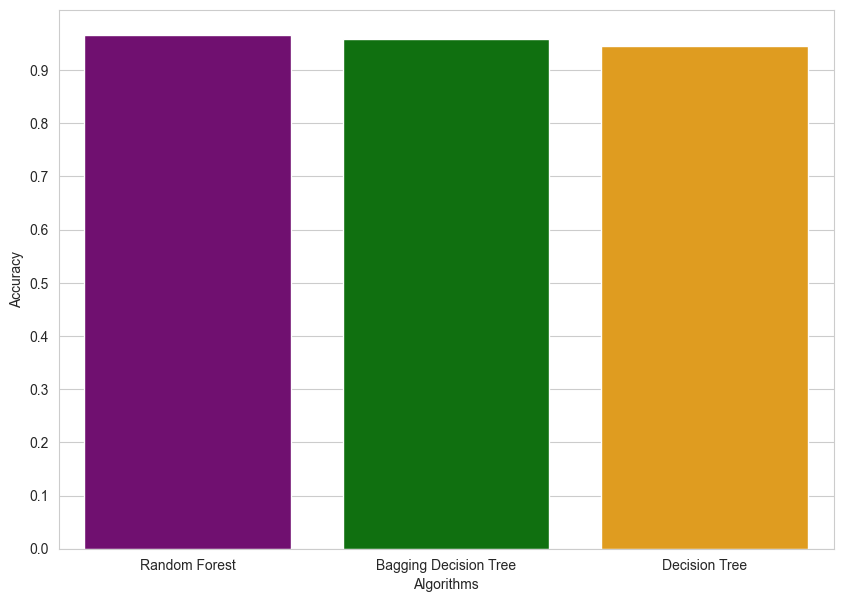

In [12]:
colors = ["purple", "green", "orange"]

sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette=colors)
plt.show()

## Confusion Matrices

In [13]:
from sklearn.metrics import confusion_matrix

# Predictions
y_pred_rf = grid_rf.best_estimator_.predict(X_test)
y_pred_bdt = grid_bdt.best_estimator_.predict(X_test)
y_pred_dt = grid_dt.best_estimator_.predict(X_test)

# Confusion Matrices
# TP FP
# FN TN
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_bdt = confusion_matrix(y_test, y_pred_bdt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

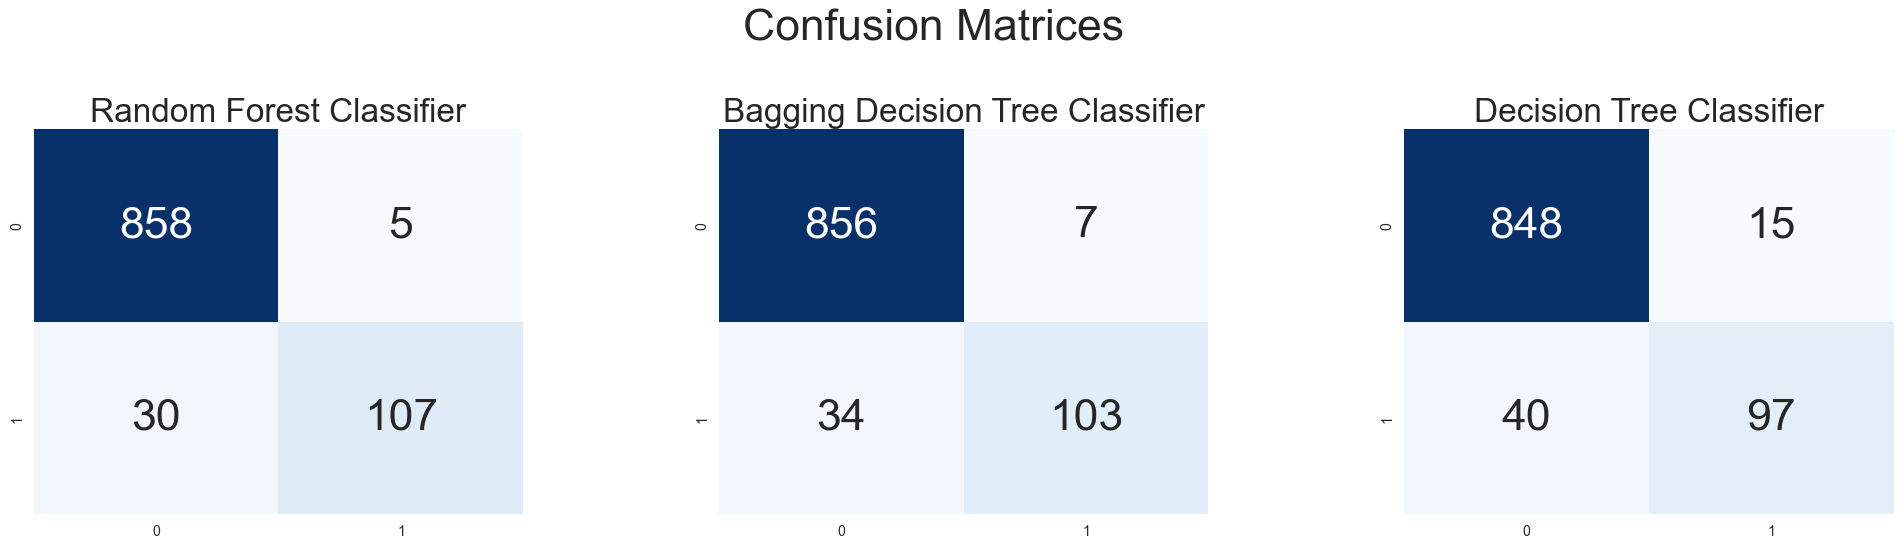

In [14]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=32)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Random Forest Classifier", fontsize=24)
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

plt.subplot(2,3,2)
plt.title("Bagging Decision Tree Classifier", fontsize=24)
sns.heatmap(cm_bdt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

plt.subplot(2,3,3)
plt.title("Decision Tree Classifier", fontsize=24)
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 32})

plt.show()

## Бонус: Подбор параметров случайного леса постепенно

Подберём сначала n_estimators и max_features.

In [15]:
n_estimators = [5, 20, 50, 100, 150, 200, 300, 500]
max_features = [2, 4, 8, len(X_train.columns)]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

random_forest = RandomForestClassifier(random_state=33, n_jobs=-1, oob_score=True)

grid_rf = GridSearchCV(estimator=random_forest, cv=cv, 
        param_grid=dict(n_estimators=n_estimators, max_features=max_features))
grid_rf.fit(X_train, y_train)
print("best score: ", grid_rf.best_score_)
print("best param: ", grid_rf.best_params_)
model_accuracies['Random Forest'] = grid_rf.score(X_test, y_test)
print("test score:", model_accuracies['Random Forest'])

best score:  0.9494150407587467
best param:  {'max_features': 8, 'n_estimators': 50}
test score: 0.962


Напишем функцию для отрисовки результатов GridSearchCV по двум параметрам

In [16]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(15, 10))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

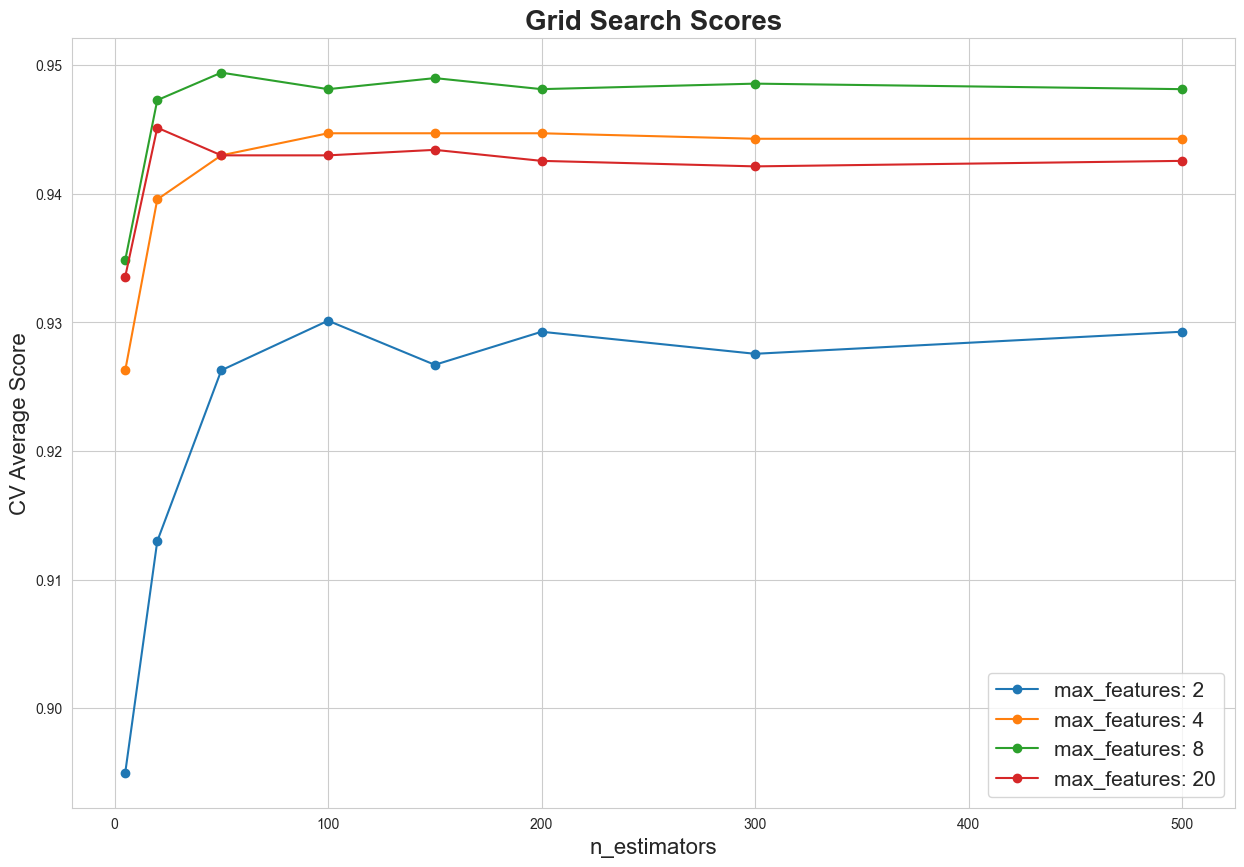

In [17]:
# Вызов функции отрисовки
plot_grid_search(grid_rf.cv_results_, n_estimators, max_features, 'n_estimators', 'max_features')

Возьмём значения n_estimators = 50, а max_features = 8. Подберём параметры criterion и max_depth.

In [18]:
n_estimators = [50]
max_features = [8]
criterion = ["gini", "entropy"]
max_depth = np.arange(1, 25)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

#добавим уже подобранные параметры
random_forest = RandomForestClassifier(random_state=33, n_jobs=-1, oob_score=True)

grid_rf = GridSearchCV(estimator=random_forest, cv=cv, 
        param_grid=dict(n_estimators=n_estimators, max_features=max_features,
                        criterion=criterion, max_depth=max_depth))
grid_rf.fit(X_train, y_train)
print("best score: ", grid_rf.best_score_)
print("best param: ", grid_rf.best_params_)
model_accuracies['Random Forest'] = grid_rf.score(X_test, y_test)
print("test score:", model_accuracies['Random Forest'])

best score:  0.9545615792520976
best param:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 8, 'n_estimators': 50}
test score: 0.97


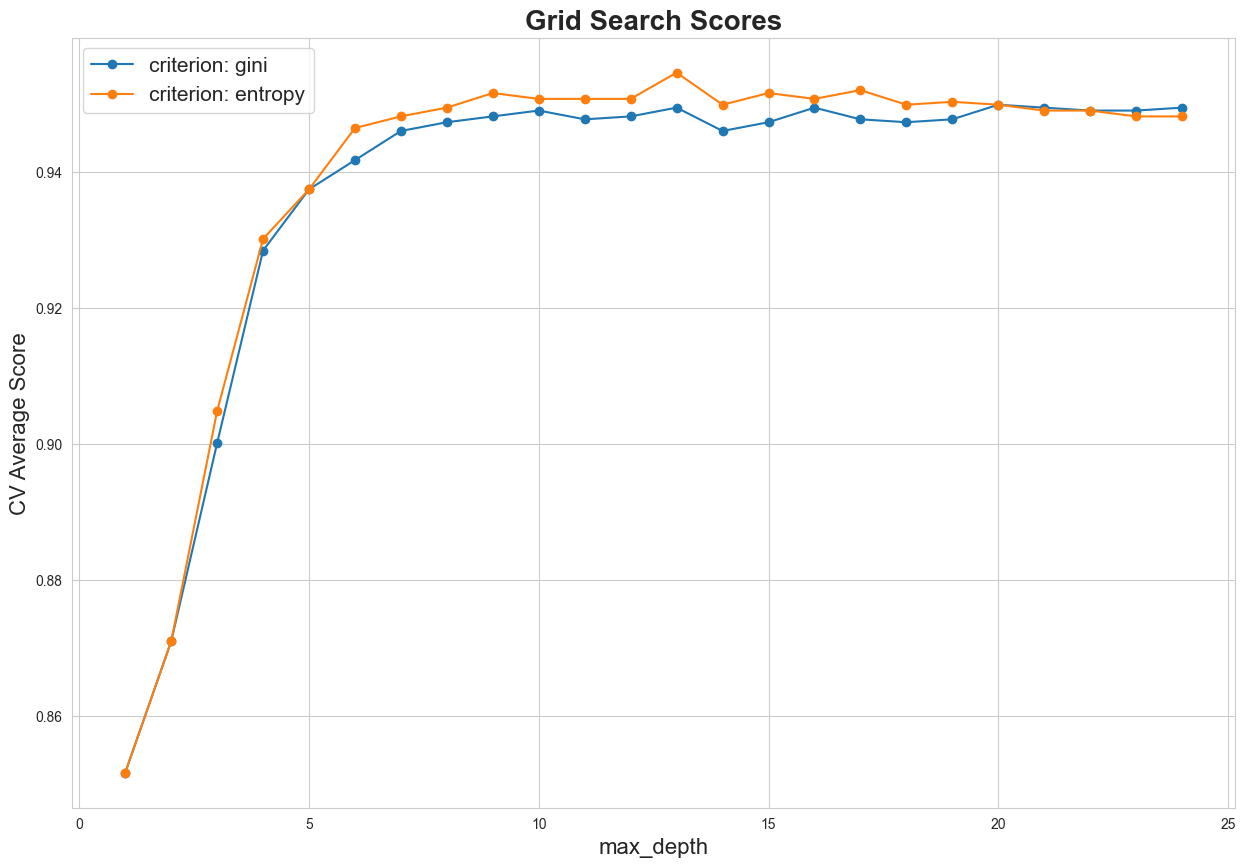

In [19]:
# Вызов функции отрисовки
plot_grid_search(grid_rf.cv_results_, max_depth, criterion, 'max_depth', 'criterion')

После max_depth где то равного 8-13 модель особо не увеличивает точность и переобучается. Возьмём max_depth где то в этом диапазоне и criterion = 'entropy', так как этот криетрий показывает более высокое качество для этих значений глубины. Далее, для окончательной модели подберём параметры возле найденных лучших.

In [20]:
n_estimators = [50, 60, 70]
max_features = [7, 8, 9]
criterion = ["entropy"]
max_depth = np.arange(8, 15)
min_samples_split = [2, 4, 10]
min_samples_leaf = [1, 2, 4]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

random_forest = RandomForestClassifier(random_state=33, n_jobs=-1, oob_score=True)

grid_rf = GridSearchCV(estimator=random_forest, cv=cv, 
        param_grid=dict(n_estimators=n_estimators, max_features=max_features,
                        criterion=criterion, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf))
grid_rf.fit(X_train, y_train)
print("best score: ", grid_rf.best_score_)
print("best param: ", grid_rf.best_params_)
model_accuracies['Random Forest'] = grid_rf.score(X_test, y_test)
print("test score:", model_accuracies['Random Forest'])

best score:  0.9545615792520976
best param:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
test score: 0.97


In [21]:
print("Accuracy of Random Forest: {:.4f}".format(model_accuracies['Random Forest']))

Accuracy of Random Forest: 0.9700


Получилось улучшить качество случайного леса, анализируя изменения качества модели по каждому параметру и сужая диапозон наиболее интересных значений для подбора.